In [ ]:
#hide
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from nbdev import *

In [ ]:
#default_exp annotate

# Annotate

> Tools to support creating and process annotation for samples of [Newspaper Navigator](news-navigator.labs.loc.gov/) data using [Label Studio](https://labelstud.io/).

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from nnanno.core import *

In [ ]:
#export
from tqdm.notebook import trange, tqdm
import pandas as pd
from pandas import json_normalize
import simplejson as json
import requests
import re
from glob import glob
from pathlib import Path

In [ ]:
#export
import nnanno
from typing import Union, Optional

## Annotating Newspaper Navigator data

Once you have created a sample of Newspaper Navigator data you might want to annotate it in some way. These annotations may function as the input for a machine learning model or could be used directly to explore images in the newspaper navigator data. There are some examples in the example directory which show how annotations can be used to generate training data for machine learning tasks. # TODO add link

## Setup annotation task
The bulk of annotation work is outsourced to label studio, label studio is a flexible annotations system which supports annotations for a range of types of data including images and text. This module does a few steps to help process annotations produced through label studio. This module is largely some suggestions on how you can get label studio setup with data from Newspaper Navigator. 

First we'll create a small sample of images we want to annotate. If you have already done this step you can skip this. 

In [ ]:
from nnanno.sample import *

In [ ]:
sampler = nnSampler()

In [ ]:
df = sampler.create_sample(50,'photos', start_year=1910, end_year=1920, year_sample=False)

As a reminder of what this data looks like

In [ ]:
df.head(1)

,filepath,pub_date,page_seq_num,edition_seq_num,batch,lccn,box,score,ocr,place_of_publication,geographic_coverage,name,publisher,url,page_url
0,curiv_mecca_ver01/data/sn85066387/00175046677/1910112701/0633/009_0_95.jpg,1910-11-27,633,1,curiv_mecca_ver01,sn85066387,"[0.15155920638426648, 0.06995691607722158, 0.28669979268699913, 0.25818633030654564]",0.954293,"[Amateur, Athletic, Union's, President]",San Francisco [Calif.],[California--San Francisco--San Francisco],The San Francisco call. [volume],Charles M. Shortridge,https://news-navigator.labs.loc.gov/data/curiv_mecca_ver01/data/sn85066387/00175046677/1910112701/0633/009_0_95.jpg,https://chroniclingamerica.loc.gov/data/batches/curiv_mecca_ver01/data/sn85066387/00175046677/1910112701/0633.jp2


There are a few ways in which we can use label studio to annotate. We could download images from our sample using `sample.download_sample`. If we have a large sample though we might want to do some annotating before we download all of these  images locally. 

label studio supports annotating form a url. We can use this in combination with IIIF to annotate images without having to download them all first. Since IIIF is such a flexible interface for getting images this also gives us flexibility in annotating at a lower resolution/size before downloading higher res images. 

## Create label studio annotation tasks

label studio supports a load of different ways of setting up 'tasks'. In this context a 'task' is an image to be annotated. One way of setting up a task is to import a `JSON` file which includes tasks. To do this we take an existing sample DataFrame and add an additional column `image` which contains a IIIF URL. 

In [ ]:
#export
def create_label_studio_json(sample: Union[pd.DataFrame,nnanno.sample.nnSampler],
                             fname: Union[str,Path], 
                             original: bool = True,  
                             pct: Optional[int] = None,
                             size: Optional[tuple] = None, 
                             preserve_asp_ratio: bool = True):
    """create a json file which can be used to upload tasks to label studio"""
    if Path(fname).exists():
        raise FileExistsError(f"{fname} already exists")
    if fname is None:
        today = datetime.today()
        time_stamp = today.strftime("%Y_%d_%m_%H_%M")
        fname = f"{time_stamp}_tasks.json"
    if type(sample) == nnanno.sample.nnSampler:
        try:
            sample = sample.sample.copy()
        except AttributeError as e:
            print(f"{sample} doesn't have a sample associated with it")
    else:
        sample = sample.copy()
    sample["image"] = sample.apply(
        lambda x: iiif_df_apply(x,
                                original=original,
                                pct=pct,
                                size=size,
                                preserve_asp_ratio=preserve_asp_ratio), axis=1)
    label_studio_json = sample.apply(lambda x:x.to_dict(), axis=1).to_list()
    with open(fname, 'w') as f:
        json.dump(label_studio_json,f, ignore_nan=True)

We can pass in either a dataframe or `nnSampler` to `create_label_studio_json`. This is a simple function which will create a `JSON` file which can be used to create 'tasks' in labels studio. In this example we pass in a size parameters. This is used to generate a IIIF URL which will request this size. 

In [ ]:
create_label_studio_json(df,'tasks.json', size=(500,500))

In [ ]:
#hide
Path('tasks.json').unlink()

This creates a `JSON` file we can use to load tasks into label studio. 


### Importing tasks into label studio
To avoid this documentation becoming out of date I haven't included screenshots etc. However, you can currently (January 2021) create tasks in label studio via the GUI or by passing in tasks through the CLI. For example to load the tasks and create a template for annotating classifications

```bash
label-studio init project_name --template=image_classification --input-path=tasks.json
```


You can then start label-studio and complete the rest of the setup via the GUI. 


```bash
label-studio start ./project_name
```

## Setting up labeling

For a proper introduction to configuring your labels consult the label studio [documentation](https://labelstud.io/guide/). One way in which you can setup labels is to use a template as shown above for setting up image classification. There are other [templates](https://labelstud.io/templates/) for other tasks. These templates consist of `XML` templates that are used to define your labels. These templates allow you to both define how you want to label your images and to share these definitions with others. For example

```xml
<View>
  <Choices name="choice" toName="image" showInLine="true" choice="multiple">
        <Choice value="human"/>
    	<Choice value="animal"/>
    	<Choice value="human-structure"/>
     	<Choice value="landscape"/>
  </Choices>
<Image name="image" value="$image"/>
</View>
```

There are a bunch of other options you can change in label studio, and features such as adding a machine learning backend to support annotations. These are discussed in more detail in the label studio documentation. 

### Notes on labeling using IIIF images

There are a few things to consider and be aware of when loading images via IIIF in label studio.

#### Missing images
Occasionally when you are doing your annotations in label studio for IIIF URLs you will get a missing image error. This is probably because for some reason the IIIF URL has been generated incorrectly for that image or that image doesn't exist via IIIF. If this happens you can 'skip' this image in the annotation interface. 

#### Setting a comfortable size for viewing 
You can take advantage of the flexibility of IIIF by requesting images to be a certain size when you create the tasks. This also helps to speed up the process of loading each image since we often end up requesting a smaller sized image to comfortably fit it in on a smallish screen. 

#### Annotating vs training image size, resolution etc. 
IF you are doing annotation of labels or classifications then you may decide to annotate at a smaller size or quality and work with a higher quality image when you come to training a model. If you are doing any annotations of pixels or regions of the image you will want to be careful to make sure these aren't lost if moving between different sizes of image. 

### Exporting and loading annotations from label studio 

Label studio supports a broad range of annotation tasks which may require particular export formats i.e. COCO or VOC for object detection. Since the processing of these outputs is tasks specific this module only contains functionality to deal with image classification and labelling tasks since these were the tasks covered in the Programming Historian lessons for which this code was originally written. 

### Exporting and processing CSV 

Once you have finished annotating all your images or got too bored of annotating you can export in a variety of formats including JSON and CSV. For simple tasks a CSV export is often sufficient and has the additional benefit of having a lower barrier to entry than JSON for people who aren't coders. 

We'll now process the annotations we generated above and labeled using label studio. The export to csv file. 

In [ ]:
#exports 
def load_annotations_csv(csv: Union[str, Path], kind='classification'):
    if kind == 'classification':
        df = pd.read_csv(csv, converters={'box':eval})
        df['label'] = df['choice']
        return df
    if kind == 'label':
        df = pd.read_csv(csv, converters={'box':eval, 'choice':eval})
        df['label'] = df.apply(lambda x: x.choice['choices'], axis=1)
        return df

As you can see this code doesn't do very much to process the annotations into a DataFrame. The main things to note are the `kind` parameter. The CSV export for labeling tasks includes a column which contains a JSON with the labels. In this case we use a pandas converter and `eval` and grab the choices which returns a list of labels. 

If we look at the columns from the annotation DataFrame we'll see that label studio kept the original metadata and we now have a new column `label` which contains our annotations. We also have a column `choice` which contains the original column format from the label studio export which will be different from the `label` column when processing labeling annotations. 

In [ ]:
annotation_df = load_annotations_csv('test_iiif_anno/label_studio_export.csv')
annotation_df.columns

Index(['batch', 'box', 'edition_seq_num', 'filepath', 'geographic_coverage',
       'image', 'lccn', 'name', 'ocr', 'page_seq_num', 'page_url',
       'place_of_publication', 'pub_date', 'publisher', 'score', 'url', 'id',
       'choice', 'label'],
      dtype='object')

In [ ]:
#hide
assert 'choice' in annotation_df.columns

We can now do the usual Pandas things to start exploring our annotations further. For example we can see how many of each label option we have

In [ ]:
annotation_df['choice'].value_counts()

Human       52
no_human    16
Name: choice, dtype: int64

### Downloading the images associated with annotations

\ # TODO add section on downloading images



In [ ]:
sampler.download_sample('test_iiif_anno/test_dl',df=annotation_df, json_name='test_dl')

In [ ]:
# TODO Moving to the cloud

In [ ]:
# test we have a very similar number of images downloaded and in our annotation dataframe 
# allow for some images to be missing
images = list(Path('test_iiif_anno/test_dl').rglob('*.jpg'))
test_close(len(images),len(annotation_df),eps=1)

### Loading with fastai

In [ ]:
#slow
from fastai.vision.all import *

In [ ]:
#slow
df = pd.read_json('test_iiif_anno/test_dl/test_dl.json')

In [ ]:
#slow
dls = ImageDataLoaders.from_df(df, path='test_iiif_anno/test_dl', 
                               fn_col='download_image_path', 
                               label_col='choice',
                               item_tfms=Resize(64), bs=4)

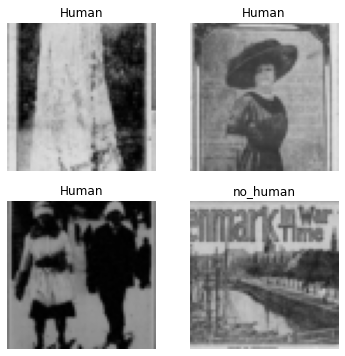

In [ ]:
#slow
dls.show_batch()

In [ ]:
#slow
[f.unlink() for f in Path('test_iiif_anno/test_dl').iterdir()]
Path('test_iiif_anno/test_dl').rmdir()

# Process completions directly 

\ # TODO add disclaimer 

In [ ]:
#export
def load_df(json_file):
    with open(json_file) as f:
        data = json.load(f)
        df = json_normalize(data,record_path=['completions'],meta=['data'])
       # df['result'] = df['result'].apply(lambda x: return_choice(x[0]) if len([x][0]) ==1 else x)
        df['result'] = df['result'].apply(lambda x: x[0]['value']['choices'] if len([x][0]) ==1 else x)
        return df

In [ ]:
#export
def load_completions(path):
    filenames = glob(f'{path}/completions/*.json')
    dataframes = [load_df(f) for f in filenames]
    return pd.concat(dataframes)

In [ ]:
#slow
df = load_completions('../ph/ads/ad_annotations/')
df.head(1)

,created_at,id,lead_time,result,data
0,1602237290,457001,1.014,[illustrations],{'image': 'http://localhost:8081/data/upload/d...


In [ ]:
#slow
#df = load_completions('../ph/photos/multi_label/')
#df.head(1)

In [ ]:
#exporti
def _df_to_csv(df,out_fn):
    df[['data','result']].to_csv(out_fn,header=['file','label',],index=False)

In [ ]:
#exporti
def _df_to_json(df,out_fn):
    df[['data','value.choices']].to_json(out_fn)

In [ ]:
#exporti
def _df_to_pkl(df,out_fn):
    df.to_pickle(out_fn)

In [ ]:
#exporti
def get_og_filepath(x):
    """
    Transforms a filepaths from processed ImageStudio format back to the Orginal Newspaper Navigator filepath  format
    """
    b, m, e = re.split('(_data_)',x)
    m = m.replace('_','/')
    e = re.split('(\d{3}_\d{1}_\d{2}.jpg)',e)
    return b+m+e[0].replace('_','/') +e[1]

In [ ]:
#export
def anno_sample_merge(sample_df: pd.DataFrame, annotation_df: pd.DataFrame) -> pd.DataFrame:
    """anno_sample_merge merges a DataFrame containing a sample
    from Newspaper Navigator and a DataFrame containing annotations

    Parameters
    ----------
    sample_df : pd.DataFrame
        A Pandas DataFrame which holds a sample from Newspaper Navigator Generated by `sample.nnSample()`
    annotation_df : pd.DataFrame
        A pandas DataFrame containing annotations loaded via the `annotate.nnAnnotations` class


    Returns
    -------
    pd.DataFrame
        A new DataFrame which merges the two input DataFrames
    """
    sample_df, annotation_df = sample_df.copy(), annotation_df.copy()
    annotation_df['id'] = annotation_df['data'].map(lambda x:get_og_filepath(x))
    return sample_df.merge(annotation_df, left_on='filepath',right_on='id')

In [ ]:
sample_df= pd.read_csv('../ph/ads/sample.csv', index_col=0)

In [ ]:
#export

class nnAnnotations:
    def __init__(self, df):
        self.annotation_df = df
        self.labels = df['result'].unique()
        self.label_counts = df['result'].value_counts()

    def __repr__(self):
        return (f'{self.__class__.__name__}'
                f' #annotations:{len(self.annotation_df)}')

    @classmethod
    def from_completions(cls, path, kind, drop_dupes=True, sample_df=None):
        df = load_completions(path)
        df = df.reset_index(drop=True) # add index
        df['data']= df['data'].map(lambda x: x['image'])
        df['data'] = df['data'].map(lambda x: x.split('?')[0])
        df['data'] = df['data'].apply(lambda x: Path(x).name)
        if any(df['data'].str.contains('-')): # removes labelstudio hash from data loaded via web interface
            df['data'] = df['data'].str.split('-',expand=True)[1]
        if drop_dupes:
            df = df.drop_duplicates(subset='data',keep='last')
        if kind=='classification':
            empty_rows = df[df['result'].apply(lambda x:len(x)==0)].index
            df = df.drop(empty_rows)
            df['result'] = df['result'].map(lambda x: x[0])
        if kind=='label':
            df['result'] = df['result'].map(lambda x: "|".join(map(str,x)) if len(x) >=1 else x)
            df['result'] = df['result'].map(lambda x:"" if len(x)==0 else x)
        return cls(df)

    def merge_sample(self, sample_df):
        self.merged_df = anno_sample_merge(sample_df,self.annotation_df)

    def export_merged(self, out_fn):
        self.merged_df.to_csv(out_fn)

    def export_annotations(self, out_fn):
        df = self.annotation_df
        if not Path(out_fn).exists():
            Path(out_fn).touch()
        suffix = Path(out_fn).suffix
        if suffix == '.csv':
            _df_to_csv(df, out_fn)
        if suffix == '.json':
            _df_to_json(df,out_fn)
        if suffix == '.pkl':
            _df_to_pkl(df,out_fn)

In [ ]:
show_doc(nnAnnotations)

<h2 id="nnAnnotations" class="doc_header"><code>class</code> <code>nnAnnotations</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>nnAnnotations</code>(**`df`**)



In [ ]:
show_doc(nnAnnotations.from_completions)

<h4 id="nnAnnotations.from_completions" class="doc_header"><code>nnAnnotations.from_completions</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>nnAnnotations.from_completions</code>(**`path`**, **`kind`**, **`drop_dupes`**=*`True`*, **`sample_df`**=*`None`*)



In [ ]:
annotations = nnAnnotations.from_completions('../ph/ads/ad_annotations/', 'classification')

In [ ]:
annotations

nnAnnotations #annotations:549

In [ ]:
annotations.labels

array(['illustrations', 'text-only'], dtype=object)

In [ ]:
annotations.label_counts

text-only        376
illustrations    173
Name: result, dtype: int64

In [ ]:
show_doc(nnAnnotations.merge_sample)

<h4 id="nnAnnotations.merge_sample" class="doc_header"><code>nnAnnotations.merge_sample</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>nnAnnotations.merge_sample</code>(**`sample_df`**)



In [ ]:
annotations.merge_sample(sample_df)
annotations.merged_df.head(2)

,filepath,pub_date,page_seq_num,edition_seq_num,batch,lccn,box,score,ocr,place_of_publication,geographic_coverage,name,publisher,url,page_url,created_at,id,lead_time,result,data
0,iahi_gastly_ver01/data/sn82015737/00279529091/...,1860-03-09,447,1,iahi_gastly_ver01,sn82015737,"[Decimal('0.30762831315880534'), Decimal('0.04...",0.950152,"['JTO', 'TMCE', 'An', 't%E', '3eott', 'County'...","Davenport, Iowa",['Iowa--Scott--Davenport'],Daily Democrat and news. [volume],"Maguire, Richardson & Co.",https://news-navigator.labs.loc.gov/data/iahi_...,https://chroniclingamerica.loc.gov/data/batche...,1602237486,iahi_gastly_ver01/data/sn82015737/00279529091/...,0.838,text-only,iahi_gastly_ver01_data_sn82015737_00279529091_...
1,ohi_cobweb_ver04/data/sn85026050/00280775848/1...,1860-08-17,359,1,ohi_cobweb_ver04,sn85026050,"[Decimal('0.5799164973813336'), Decimal('0.730...",0.985859,"['9', 'BI.', 'I', '.QJtf', 'A', 'never', 'fall...","Fremont, Sandusky County [Ohio]",['Ohio--Sandusky--Fremont'],Fremont journal. [volume],I.W. Booth,https://news-navigator.labs.loc.gov/data/ohi_c...,https://chroniclingamerica.loc.gov/data/batche...,1602236992,ohi_cobweb_ver04/data/sn85026050/00280775848/1...,7.593,illustrations,ohi_cobweb_ver04_data_sn85026050_00280775848_1...


In [ ]:
show_doc(nnAnnotations.export_merged)

<h4 id="nnAnnotations.export_merged" class="doc_header"><code>nnAnnotations.export_merged</code><a href="__main__.py#L36" class="source_link" style="float:right">[source]</a></h4>

> <code>nnAnnotations.export_merged</code>(**`out_fn`**)



In [ ]:
annotations.export_merged('testmerge.csv')

In [ ]:
show_doc(nnAnnotations.from_completions)

<h4 id="nnAnnotations.from_completions" class="doc_header"><code>nnAnnotations.from_completions</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>nnAnnotations.from_completions</code>(**`path`**, **`kind`**, **`drop_dupes`**=*`True`*, **`sample_df`**=*`None`*)



In [ ]:
#hide 
Path('testmerge.csv').unlink()

In [ ]:
annotations = nnAnnotations.from_completions('../ph/ads/ad_annotations/', 'classification')
annotations.annotation_df.head(2)

,created_at,id,lead_time,result,data
0,1602237290,457001,1.014,illustrations,txdn_argentina_ver01_data_sn84022109_002111018...
1,1602237157,179001,2.068,text-only,khi_earhart_ver01_data_sn85032814_00237283260_...


In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_sample.ipynb.
Converted 02_annotate.ipynb.
Converted 03_inference.ipynb.
Converted index.ipynb.
